In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import itertools
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = {}
for i in range(len(root_tweet_names)):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce')
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    
    tweet_dfs[i] = tweet_df

In [27]:
tweet_name_to_index = {}
for i in range(len(root_tweet_names)):
    tweet_name_to_index[root_tweet_names[i]] = i
for key in tweet_name_to_index.keys():
    print key

Source_followers_tweet_0137_Therealkiss.txt
Source_followers_tweet_0108_newtgingrich.txt
Source_followers_tweet_0533_BarackObama.txt
Source_followers_tweet_0345_KimKardashian.txt
Source_followers_tweet_0069_bobatl.txt
Source_followers_tweet_0101_myfabolouslife.txt
Source_followers_tweet_0024_pbsgwen.txt
Source_followers_tweet_0176_AnnCoulter.txt
Source_followers_tweet_1134_JLin7.txt
Source_followers_tweet_0608_rickyrozay.txt
Source_followers_tweet_0294_myfabolouslife.txt
Source_followers_tweet_0462_AnnDRomney.txt
Source_followers_tweet_0506_billmaher.txt
Source_followers_tweet_0611_BarackObama.txt
Source_followers_tweet_0189_sethmeyers21.txt
Source_followers_tweet_0167_rickyrozay.txt
Source_followers_tweet_0031_CNET.txt
Source_followers_tweet_0044_JonnyBones.txt
Source_followers_tweet_0127_hilaryr.txt
Source_followers_tweet_0074_Tip.txt
Source_followers_tweet_0026_realMickFoley.txt
Source_followers_tweet_0127_newtgingrich.txt
Source_followers_tweet_0070_E40.txt
Source_followers_tweet_0

In [28]:
def format_partition_file_name(name):
    root = name.split('.')
    items = root[0].split('_')
    items[-2], items[-1] = items[-1], items[-2]
    return ".".join(["_".join(items), root[-1]])

In [31]:
path = '../RetweetDataAOAS/Partition/'
partition_names = [f for f in listdir(path) if isfile(join(path, f))]
partitions = {}
# for i in range(len(partition_names)):
for i in range(1, 2):
    print i
    partitions[i] = {}
    partition_df = pd.read_excel(path+partition_names[i], encoding = "ISO-8859-1")
    for index, row in partition_df.iterrows():
        training_file_name = format_partition_file_name(row['Training'])
        prediction_file_name = format_partition_file_name(row['Prediction'])
        print "\n", training_file_name
        print prediction_file_name
        partitions[i][tweet_name_to_index[training_file_name]] = True
        partitions[i][tweet_name_to_index[prediction_file_name]] = False
    print partitions[i]
    

1

Source_followers_tweet_0022_Lawrence.txt
Source_followers_tweet_0024_pbsgwen.txt

Source_followers_tweet_0026_realMickFoley.txt
Source_followers_tweet_0028_AnnCoulter.txt

Source_followers_tweet_0031_ASAPYams.txt
Source_followers_tweet_0031_CNET.txt

Source_followers_tweet_0037_EvaLongoria.txt
Source_followers_tweet_0044_JonnyBones.txt

Source_followers_tweet_0048_MissInfoTV.txt
Source_followers_tweet_0068_CharlesMBlow.txt

Source_followers_tweet_0069_bobatl.txt
Source_followers_tweet_0070_E40.txt

Source_followers_tweet_0074_Tip.txt
Source_followers_tweet_0074_iamwill.txt

Source_followers_tweet_0085_MrChuckD.txt
Source_followers_tweet_0091_CharlesMBlow.txt

Source_followers_tweet_0092_AnnCoulter.txt
Source_followers_tweet_0092_jasonsegel.txt

Source_followers_tweet_0101_GarryShandling.txt
Source_followers_tweet_0101_Pitbull.txt

Source_followers_tweet_0101_myfabolouslife.txt
Source_followers_tweet_0107_djkhaled.txt

Source_followers_tweet_0108_newtgingrich.txt
Source_followers_twe

In [5]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

In [6]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [7]:
tweet_df_1 = tweet_dfs[1]
s_j_x = sorted(generate_reaction_times(tweet_df_1).values())
log_s_j_x = [np.log(i.seconds) for i in s_j_x]
tweet_df_1_users = list(tweet_df_1['UserId'])
m_j_x_dic = generate_number_of_follower_who_retweet(tweet_df_1)
m_j_x_lis = []
for key in m_j_x_dic.keys():
    m_j_x_lis.append(m_j_x_dic[key])

In [8]:
print(root_tweet_names)

['Source_followers_tweet_0074_iamwill.txt', 'Source_followers_tweet_0127_hilaryr.txt', 'Source_followers_tweet_0271_hilaryr.txt', 'Source_followers_tweet_0022_Lawrence.txt', 'Source_followers_tweet_0024_pbsgwen.txt', 'Source_followers_tweet_0026_realMickFoley.txt', 'Source_followers_tweet_0028_AnnCoulter.txt', 'Source_followers_tweet_0031_ASAPYams.txt', 'Source_followers_tweet_0031_CNET.txt', 'Source_followers_tweet_0037_EvaLongoria.txt', 'Source_followers_tweet_0044_JonnyBones.txt', 'Source_followers_tweet_0048_MissInfoTV.txt', 'Source_followers_tweet_0068_CharlesMBlow.txt', 'Source_followers_tweet_0069_bobatl.txt', 'Source_followers_tweet_0070_E40.txt', 'Source_followers_tweet_0074_Tip.txt', 'Source_followers_tweet_0085_MrChuckD.txt', 'Source_followers_tweet_0091_CharlesMBlow.txt', 'Source_followers_tweet_0092_AnnCoulter.txt', 'Source_followers_tweet_0092_jasonsegel.txt', 'Source_followers_tweet_0101_GarryShandling.txt', 'Source_followers_tweet_0101_myfabolouslife.txt', 'Source_follo

In [8]:
with pm.Model() as strawman_model:
    lamb = pm.Gamma('lambda', alpha=1, beta=1./500)
    m_preds = pm.Poisson('follower_count', mu=lamb, observed=m_j_x_lis, shape=len(m_j_x_lis))

In [9]:
# Run and fit our model
with strawman_model:
    trace = pm.sample(1000, tune=2000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_log__]
100%|██████████| 3000/3000 [00:01<00:00, 2079.59it/s]


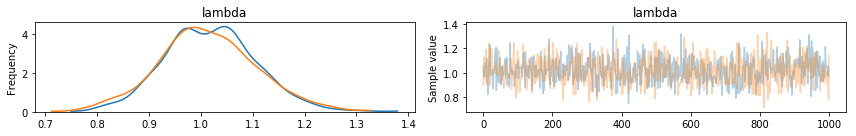

In [10]:
with strawman_model:
    pm.traceplot(trace);


In [33]:
partitions

{1: {0: False,
  1: True,
  2: True,
  3: True,
  4: False,
  5: True,
  6: False,
  7: True,
  8: False,
  9: True,
  10: False,
  11: True,
  12: False,
  13: True,
  14: False,
  15: True,
  16: True,
  17: False,
  18: True,
  19: False,
  20: True,
  21: True,
  22: False,
  23: False,
  24: True,
  25: False,
  26: False,
  27: True,
  28: False,
  29: True,
  30: False,
  31: True,
  32: False,
  33: True,
  34: False,
  35: True,
  36: False,
  37: False,
  38: True,
  39: False,
  40: True,
  41: False,
  42: True,
  43: False,
  44: True,
  45: False,
  46: True,
  47: False,
  48: True,
  49: False,
  50: True,
  51: False}}

In [53]:
# linear regression model setup

followers_train = []
retweets_train = []
followers_test = []
retweets_test = []

for i in range(len(root_tweet_names)):
    # todo: need to do train / test split
    count = int(tweet_dfs[i].iloc[0]["FollowerCount"])
    if partitions[1][i]: # currently hard-coded to look at first partition
        followers_train.append(count)
        retweets_train.append(len(tweet_dfs[i]) - 1) 
    else:
        followers_test.append(count)
        retweets_test.append(len(tweet_dfs[i]) - 1) 

followers_train_log = np.log(np.array(followers_train))
retweets_train_log = np.log(np.array(retweets_train))

followers_test_log = np.log(np.array(followers_test))
retweets_test_log = np.log(np.array(retweets_test))

data = dict(x = followers_train_log, y = retweets_train_log)

In [37]:
with pm.Model() as linear_regression_model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    beta_0 = pm.Normal('beta_0', 0, sd=20)
    beta_1 = pm.Normal('beta_1', 0, sd=20)
    
#     error_array = []
#     for i in range(len(root_tweet_names)):
#         # todo: need to do train / test split
#         e_x = pm.Normal("e_{}".format(i), 0, sd=100) #what to set for sd
#         error_array.append(e_x)
#     error_array = np.array(error_array)
        
    e_x = pm.Normal("e", 0, sd = 1, shape = (52,1))

    # Define likelihood    
    likelihood = pm.Normal('y', mu=beta_0 + beta_1 * followers_train_log + e_x,
                        sd=sigma, observed=retweets_train_log)

In [51]:
# Run and fit our model
with linear_regression_model:
#     step = pm.Metropolis()
    trace = pm.sample(5000, tune=1000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [e, beta_1, beta_0, sigma_log__]
100%|██████████| 6000/6000 [00:56<00:00, 105.58it/s]
The number of effective samples is smaller than 25% for some parameters.


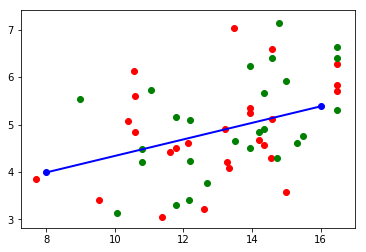

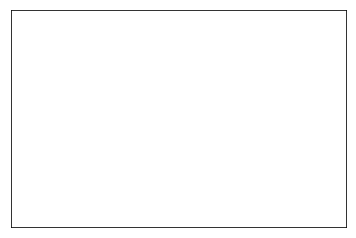

In [74]:
# Plot outputs

plt.scatter(followers_train_log, retweets_train_log,  color='red')
plt.scatter(followers_test_log, retweets_test_log,  color='green')

x_line = [8,16]
y_line = []

b_0 = np.mean(trace['beta_0'])
b_1 = np.mean(trace['beta_1'])
for val in x_line:
    y_line.append(val*b_1 + b_0)

plt.plot(x_line, y_line, 'bo-', label='line 1', linewidth=2)

fig, ax = plt.subplots()

plt.xticks(())
plt.yticks(())

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e7f68d4d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3e8fa90f50>]], dtype=object)

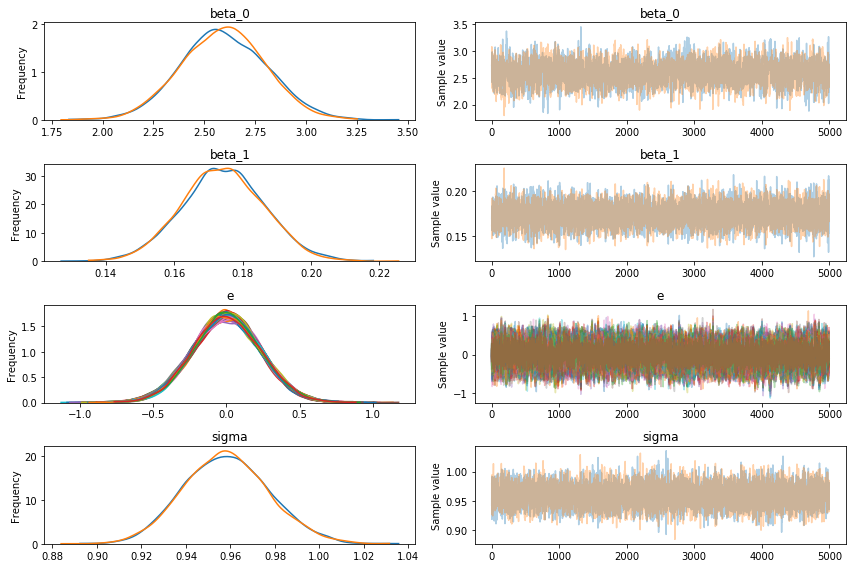

In [52]:
pm.traceplot(trace)

In [16]:
# alternative model 
with pm.Model() as glm_model:
    pm.glm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(1000, tune=3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, x, Intercept]
100%|██████████| 4000/4000 [00:11<00:00, 345.50it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7a008e9d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa79f194b50>]], dtype=object)

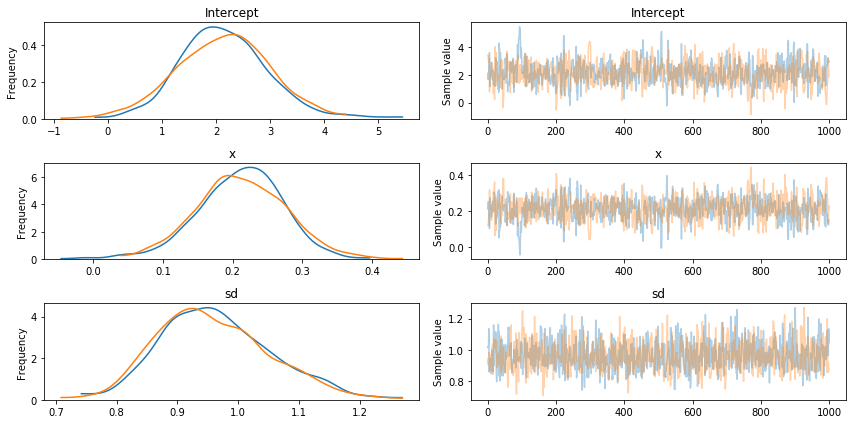

In [17]:
pm.traceplot(trace)

In [94]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [96]:
followers_array_log = np.array(followers_array, ndmin=2)
followers_array_log = np.transpose(np.log(followers_array_log))

retweets_array_log = np.array(retweets_array, ndmin=2)
retweets_array_log = np.transpose(np.log(retweets_array_log))

In [97]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(followers_array_log, retweets_array_log)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
# print("Mean squared error: %.2f"
#       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

('Coefficients: \n', array([[ 0.2106125]]))
